In [35]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
from pathlib import Path
import json

import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [19]:
dir = Path('/Users/lisepauwels/sps_simulations/Prototyping/20251009/results/')
subdirs = [p for p in dir.iterdir() if p.is_dir()]
cases = [p.stem for p in subdirs]

cases, subdirs = zip(*sorted(zip(cases, subdirs)))
cases = list(cases)
subdirs = list(subdirs)

In [23]:
with open(subdirs[0]/f'IntensityLoss_{cases[0]}.json', 'r') as fid:
    input_data = json.load(fid)

In [26]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

In [39]:
def interpolate_50_val(xvals, yvals):
    if np.any(yvals <= 0.5):  # ensure the curve actually crosses 0.5
        idx_above = np.where(yvals > 0.5)[0][-1]   # last index above 0.5
        idx_below = idx_above + 1                  # first index below 0.5

        # Linear interpolation for more accuracy
        x50 = np.interp(0.5, [yvals[idx_above], yvals[idx_below]],
                            [xvals[idx_above], xvals[idx_below]])
        return x50
    else:
        print("Warning: The curve does not cross 0.5")
        return None

case0_DPneg: delta_50 = -6.463e-3
case0_DPpos: delta_50 = 6.886e-3
case1_DPneg: delta_50 = -6.371e-3
case1_DPpos: delta_50 = 6.852e-3
case2_DPneg: delta_50 = -6.463e-3
case2_DPpos: delta_50 = 6.677e-3
case3_DPneg: delta_50 = -6.582e-3
case3_DPpos: delta_50 = 6.830e-3
case4_DPneg: delta_50 = -6.404e-3
case4_DPpos: delta_50 = 6.866e-3
case5_DPneg: delta_50 = -6.429e-3
case5_DPpos: delta_50 = 6.839e-3
case6_DPneg: delta_50 = -6.641e-3
case6_DPpos: delta_50 = 6.761e-3
case6_bis_DPneg: delta_50 = -6.412e-3
case6_bis_DPpos: delta_50 = 6.889e-3
case7_DPneg: delta_50 = -6.515e-3
case7_DPpos: delta_50 = 6.791e-3


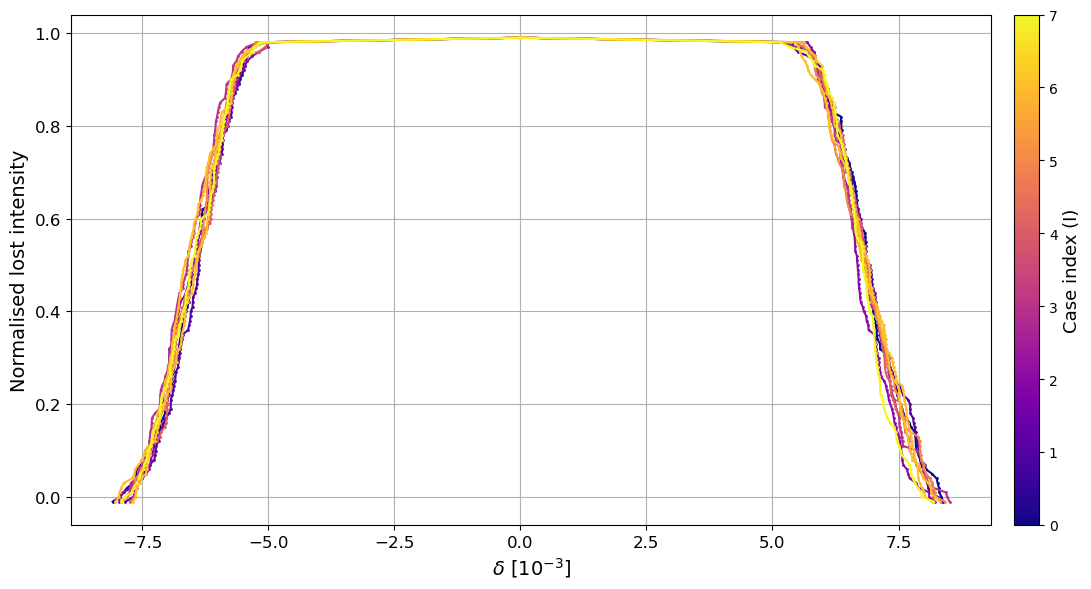

In [48]:
fig, ax = plt.subplots(figsize=(12,6))

case_indices = sorted({
    int(c.split('_')[0].replace('case', ''))
    for c in cases
    if c not in ['case7_1000part_DPneg', 'case7_1000part_DPpos', 'case6_bis_DPneg', 'case6_bis_DPpos']
})

cmap = cm.plasma
norm = mcolors.Normalize(vmin=min(case_indices), vmax=max(case_indices))
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

input_data = {}
delta_50_vals = {}
for case, subdir in zip(cases, subdirs):
    if case not in ['case7_1000part_DPneg', 'case7_1000part_DPpos']:#, 'case6_bis_DPneg', 'case6_bis_DPpos']:
        with open(subdir/f'IntensityLoss_{case}.json', 'r') as fid:
            input_data[case] = json.load(fid)
        turns = list(input_data[case].keys())
        num_particles = input_data[case]['num_particles']
        sweep_per_turn = input_data[case]['sweep_per_turn']
        turns.remove('num_particles')
        turns.remove('sweep_per_turn')

        turns = np.array(turns, dtype=int)
        deltas = df_to_delta(sweep_per_turn*turns)
        deltas = np.concatenate((np.array([0]), deltas))
        counts = np.array([input_data[case][str(turn)] for turn in turns], dtype=int)
        counts = np.concatenate((np.array([1]), counts))

        I = int(case.split('_')[0].replace('case', ''))
        color = cmap(norm(I))


        ax.plot(deltas*1e3, 1-np.cumsum(counts)/num_particles, marker='o', markersize=1, color=color, label=case)
        print(f'{case}: delta_50 = {interpolate_50_val(deltas, 1-np.cumsum(counts)/num_particles)*1e3:.3f}e-3')
        delta_50_vals[case] = float(interpolate_50_val(deltas, 1-np.cumsum(counts)/num_particles)*1e3)
ax.grid()
ax.set_xlabel(r'$\delta$ $[10^{-3}]$', fontsize=14)
ax.set_ylabel('Normalised lost intensity', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Case index (I)', fontsize=13)

fig.tight_layout()

In [49]:
delta_50_vals

{'case0_DPneg': -6.462504526392533,
 'case0_DPpos': 6.885909995363078,
 'case1_DPneg': -6.370580970629191,
 'case1_DPpos': 6.852483247812772,
 'case2_DPneg': -6.462504526392533,
 'case2_DPpos': 6.676992823173665,
 'case3_DPneg': -6.582283705114464,
 'case3_DPpos': 6.830198749445901,
 'case4_DPneg': -6.404007718179497,
 'case4_DPpos': 6.866411059292067,
 'case5_DPneg': -6.429077778842227,
 'case5_DPpos': 6.838555436333477,
 'case6_DPneg': -6.640780513327499,
 'case6_DPpos': 6.76055969204943,
 'case6_bis_DPneg': -6.412364405067074,
 'case6_bis_DPpos': 6.888695557658938,
 'case7_DPneg': -6.515430210013851,
 'case7_DPpos': 6.791200877303877}

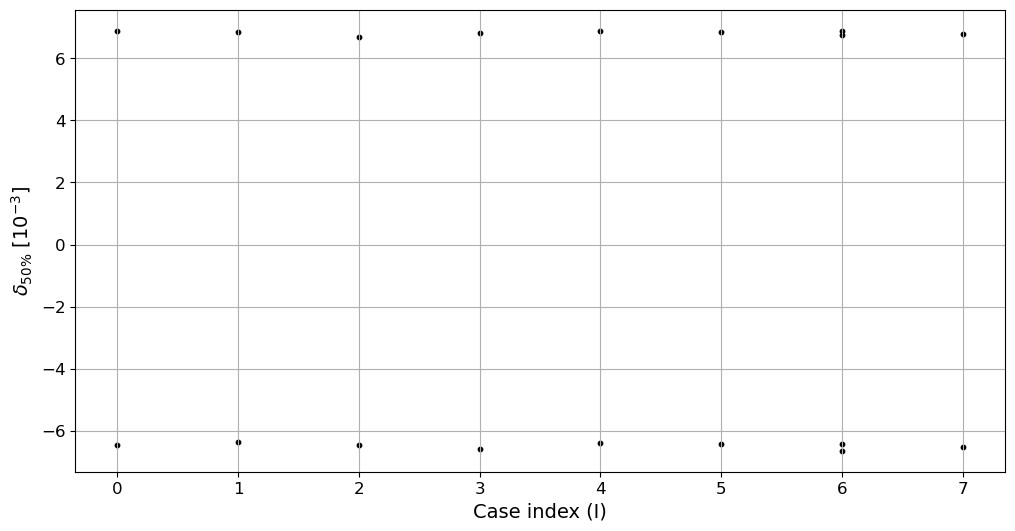

In [54]:
fig, ax = plt.subplots(figsize=(12,6))

case_indices = sorted({
    int(c.split('_')[0].replace('case', ''))
    for c in cases
    if c not in ['case7_1000part_DPneg', 'case7_1000part_DPpos', 'case6_bis_DPneg', 'case6_bis_DPpos']
})

cmap = cm.plasma
norm = mcolors.Normalize(vmin=min(case_indices), vmax=max(case_indices))
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for case in cases:
    if case not in ['case7_1000part_DPneg', 'case7_1000part_DPpos']:#, 'case6_bis_DPneg', 'case6_bis_DPpos']:
        I = int(case.split('_')[0].replace('case', ''))
        color = cmap(norm(I))
        # ax.scatter(I, delta_50_vals[case], color=color, s=10)
        ax.scatter(I, delta_50_vals[case], color='k', s=10)
ax.grid()
ax.set_xlabel('Case index (I)', fontsize=14)
ax.set_ylabel(r'$\delta_{50\%}$ $[10^{-3}]$', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

case0_DPneg
case1_DPneg
case2_DPneg
case3_DPneg
case4_DPneg
case5_DPneg
case6_DPneg
case7_DPneg


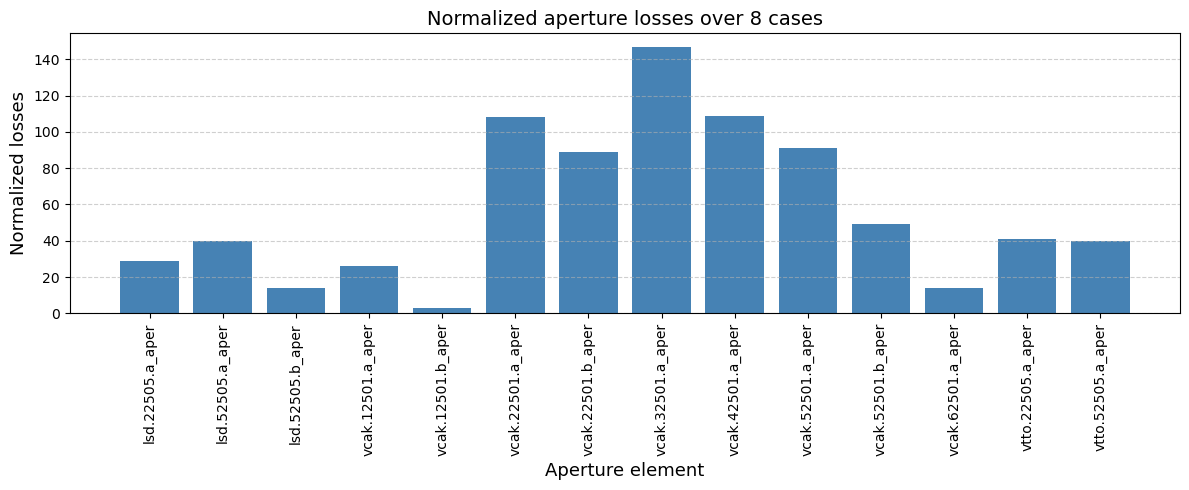

In [60]:
aper_data = {}
for subdir,case in zip(subdirs, cases):
    if case not in ['case7_1000part_DPneg', 'case7_1000part_DPpos', 'case6_bis_DPneg', 'case6_bis_DPpos'] and 'DPpos' not in case:
        print(case)
        with open(subdir/f'{case}_aper_losses.json', 'r') as fid:
            aper_data[case] = json.load(fid)
    
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# --- Combine all aperture losses across cases ---
total_losses = Counter()

for case, losses in aper_data.items():
    if 'DPneg' in case:  # only consider one plane to avoid double counting
        total_losses.update(losses)

# --- Normalization ---
num_cases = len(aper_data)
norm_factor = num_cases * 100  # each case had 100 particles

# Convert to arrays for plotting
elements, counts = zip(*sorted(total_losses.items()))
counts = np.array(counts, dtype=float)
counts_norm = counts / norm_factor  # normalize

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 5))
# ax.bar(range(len(elements)), counts_norm, color='steelblue')
ax.bar(range(len(elements)), counts, color='steelblue')
ax.set_xticks(range(len(elements)))
ax.set_xticklabels(elements, rotation=90)
ax.set_xlabel("Aperture element", fontsize=13)
ax.set_ylabel("Normalized losses", fontsize=13)
ax.set_title(f"Normalized aperture losses over {num_cases} cases", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.6)
fig.tight_layout()

plt.show()


# Orbit shifts tests

In [64]:
dir = Path('/Users/lisepauwels/sps_simulations/Prototyping/20251009/results/orbit_shifts/')
subdirs = [p for p in dir.iterdir() if p.is_dir()]
cases = [p.stem for p in subdirs]

cases, subdirs = zip(*sorted(zip(cases, subdirs)))
cases = list(cases)
subdirs = list(subdirs)

In [65]:
cases

['main_bottlenecks_apershifts_2mm_DPneg',
 'main_bottlenecks_apershifts_2mm_DPpos',
 'main_bottlenecks_apershifts_3mm_2mm_DPneg',
 'main_bottlenecks_apershifts_3mm_2mm_DPpos',
 'main_bottlenecks_apershifts_DPneg',
 'main_bottlenecks_apershifts_DPpos',
 'main_bottlenecks_qdshifts_1000part_DPneg',
 'main_bottlenecks_qdshifts_1000part_DPpos',
 'main_bottlenecks_qdshifts_3_2mm_DPneg',
 'main_bottlenecks_qdshifts_3_2mm_DPpos',
 'main_bottlenecks_qdshifts_DPneg',
 'main_bottlenecks_qdshifts_DPpos',
 'qd52510_1mm_DPneg',
 'qd52510_1mm_DPpos',
 'qd52510_qd22510_1mm_1000part_DPneg',
 'qd52510_qd22510_1mm_1000part_DPpos',
 'qd52510_qd22510_1mm_10_micado_DPneg',
 'qd52510_qd22510_1mm_10_micado_DPpos',
 'qd52510_qd22510_1mm_DPneg',
 'qd52510_qd22510_1mm_DPpos']

main_bottlenecks_apershifts_2mm_DPneg: delta_50 = -6.365e-3
main_bottlenecks_apershifts_2mm_DPpos: delta_50 = 6.891e-3
main_bottlenecks_apershifts_3mm_2mm_DPneg: delta_50 = -6.599e-3
main_bottlenecks_apershifts_3mm_2mm_DPpos: delta_50 = 6.936e-3
main_bottlenecks_apershifts_DPneg: delta_50 = -6.777e-3
main_bottlenecks_apershifts_DPpos: delta_50 = 6.928e-3
main_bottlenecks_qdshifts_3_2mm_DPneg: delta_50 = -6.106e-3
main_bottlenecks_qdshifts_3_2mm_DPpos: delta_50 = 6.894e-3
main_bottlenecks_qdshifts_DPneg: delta_50 = -6.451e-3
main_bottlenecks_qdshifts_DPpos: delta_50 = 7.014e-3


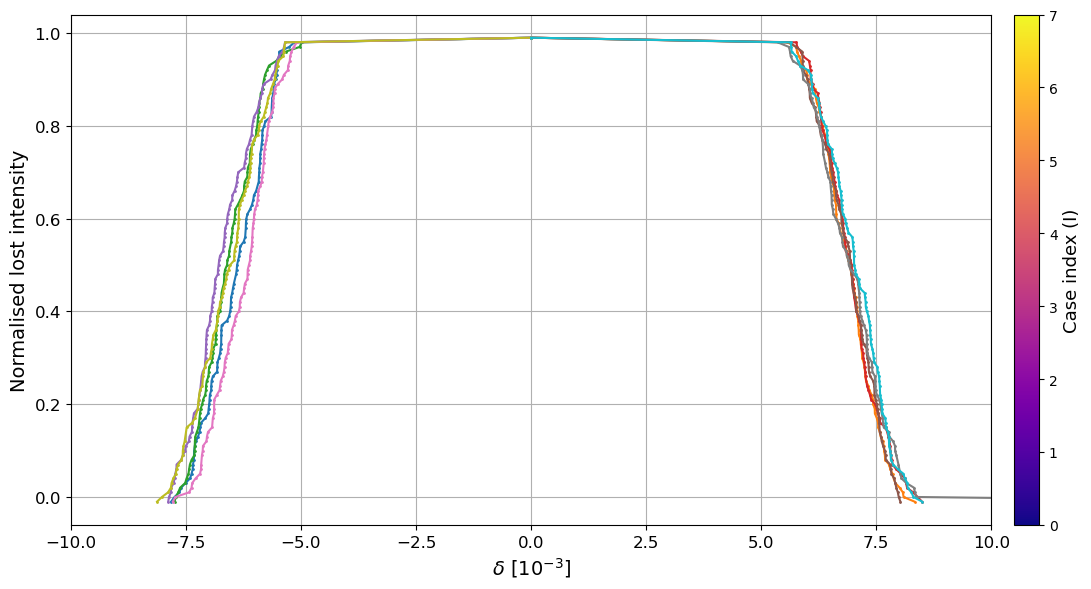

In [69]:
fig, ax = plt.subplots(figsize=(12,6))

input_data = {}
delta_50_vals = {}

for case, subdir in zip(cases, subdirs):
    if 'main' in case and '1000part' not in case:
        with open(subdir/f'IntensityLoss_{case}.json', 'r') as fid:
            input_data[case] = json.load(fid)
        turns = list(input_data[case].keys())
        num_particles = input_data[case]['num_particles']
        sweep_per_turn = input_data[case]['sweep_per_turn']
        turns.remove('num_particles')
        turns.remove('sweep_per_turn')

        turns = np.array(turns, dtype=int)
        deltas = df_to_delta(sweep_per_turn*turns)
        deltas = np.concatenate((np.array([0]), deltas))
        counts = np.array([input_data[case][str(turn)] for turn in turns], dtype=int)
        counts = np.concatenate((np.array([1]), counts))


        ax.plot(deltas*1e3, 1-np.cumsum(counts)/num_particles, marker='o', markersize=1, label=case)
        print(f'{case}: delta_50 = {interpolate_50_val(deltas, 1-np.cumsum(counts)/num_particles)*1e3:.3f}e-3')
        delta_50_vals[case] = float(interpolate_50_val(deltas, 1-np.cumsum(counts)/num_particles)*1e3)
ax.grid()
ax.set_xlabel(r'$\delta$ $[10^{-3}]$', fontsize=14)
ax.set_ylabel('Normalised lost intensity', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim(-10, 10)

fig.tight_layout()

main_bottlenecks_apershifts_2mm_DPneg: delta_50 = -6.365e-3
main_bottlenecks_apershifts_2mm_DPpos: delta_50 = 6.891e-3
main_bottlenecks_apershifts_3mm_2mm_DPneg: delta_50 = -6.599e-3
main_bottlenecks_apershifts_3mm_2mm_DPpos: delta_50 = 6.936e-3
main_bottlenecks_apershifts_DPneg: delta_50 = -6.777e-3
main_bottlenecks_apershifts_DPpos: delta_50 = 6.928e-3
main_bottlenecks_qdshifts_3_2mm_DPneg: delta_50 = -6.106e-3
main_bottlenecks_qdshifts_3_2mm_DPpos: delta_50 = 6.894e-3
main_bottlenecks_qdshifts_DPneg: delta_50 = -6.451e-3
main_bottlenecks_qdshifts_DPpos: delta_50 = 7.014e-3


/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_32826/2657552380.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')


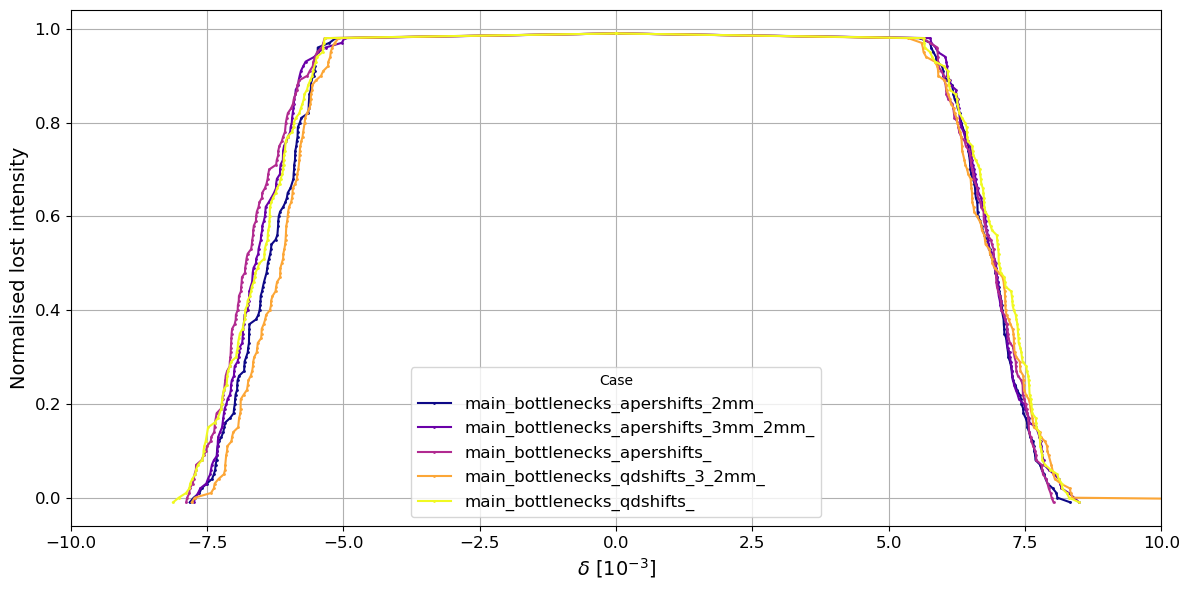

In [73]:
fig, ax = plt.subplots(figsize=(12, 6))

input_data = {}
delta_50_vals = {}

# Extract unique base names (without DPneg/DPpos)
base_names = []
for case in cases:
    base_name = case.replace('DPneg', '').replace('DPpos', '')
    if base_name not in base_names:
        base_names.append(base_name)

# Sample colors evenly from the plasma colormap
cmap = cm.get_cmap('plasma')
colors = {base: cmap(i / len(base_names) * 0.8 + 0.1) for i, base in enumerate(base_names)}
colors = {base: cmap(i / 5) for i, base in enumerate(base_names)}

for case, subdir in zip(cases, subdirs):
    if 'main' in case and '1000part' not in case:
        with open(subdir / f'IntensityLoss_{case}.json', 'r') as fid:
            input_data[case] = json.load(fid)

        turns = list(input_data[case].keys())
        num_particles = input_data[case]['num_particles']
        sweep_per_turn = input_data[case]['sweep_per_turn']
        turns.remove('num_particles')
        turns.remove('sweep_per_turn')

        turns = np.array(turns, dtype=int)
        deltas = df_to_delta(sweep_per_turn * turns)
        deltas = np.concatenate((np.array([0]), deltas))
        counts = np.array([input_data[case][str(turn)] for turn in turns], dtype=int)
        counts = np.concatenate((np.array([1]), counts))

        # Pick color based on base case name
        base_name = case.replace('DPneg', '').replace('DPpos', '')
        color = colors[base_name]

        ax.plot(
            deltas * 1e3,
            1 - np.cumsum(counts) / num_particles,
            marker='o',
            markersize=1,
            label=base_name if 'DPneg' in case else None,  # label once
            color=color,
        )

        val_50 = interpolate_50_val(deltas, 1 - np.cumsum(counts) / num_particles) * 1e3
        print(f'{case}: delta_50 = {val_50:.3f}e-3')
        delta_50_vals[case] = float(val_50)

ax.grid()
ax.set_xlabel(r'$\delta$ $[10^{-3}]$', fontsize=14)
ax.set_ylabel('Normalised lost intensity', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim(-10, 10)
ax.legend(title='Case', fontsize=12)

fig.tight_layout()
